In [ ]:
# Import library
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'

In [ ]:
path = '/Users/chaipat/hackathon/input/'
df = pd.read_csv(path + 'xGASS.csv')
print('\nNumber of rows and columns in the data set: ',df.shape)
df


Number of rows and columns in the data set:  (1179, 42)


,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,...,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB
0,11834,101866,J000047.89+141639.1,750,52235,141,0.19954,14.27755,0.036180,159.2,...,-1.106,0.0,0.490,158499,722887,1,1,0,11.9957,-3.651931
1,11892,101874,J000200.82+150132.1,751,52251,266,0.50344,15.02561,0.035730,157.2,...,-1.799,-99.0,0.634,159195,725451,1,1,0,12.0152,-3.958913
2,11825,101876,J000210.19+140810.3,750,52235,13,0.54247,14.13620,0.042010,185.7,...,-1.381,0.0,0.712,158506,722903,1,1,0,12.0821,-3.895616
3,11903,101887,J000458.72+154018.2,751,52251,426,1.24471,15.67174,0.037330,164.4,...,-1.458,-99.0,0.564,105369,353193,1,1,0,0.0000,-99.000000
4,124028,43,J000602.39+142502.8,751,52251,236,1.50998,14.41746,0.017594,76.4,...,0.300,0.0,2.294,104212,348380,1,1,0,0.0000,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,11783,332201,J235224.35+143535.1,749,52226,187,358.10150,14.59309,0.027040,118.2,...,-1.670,-99.0,0.887,7657,716763,0,4,0,12.7417,-0.709211
1175,11808,332860,J235257.31+154244.8,749,52226,419,358.23880,15.71246,0.047950,212.9,...,-1.508,1.0,0.490,105328,353091,1,1,0,12.3583,-4.170143
1176,11815,330987,J235308.28+160351.9,749,52226,450,358.28452,16.06442,0.049100,218.1,...,-1.177,1.0,0.169,3878,354729,2,6,0,13.4154,-0.929183
1177,11845,331571,J235644.47+135435.4,750,52235,288,359.18533,13.90986,0.036330,159.9,...,-0.769,1.0,0.712,7652,714340,0,4,0,12.7979,-0.515802


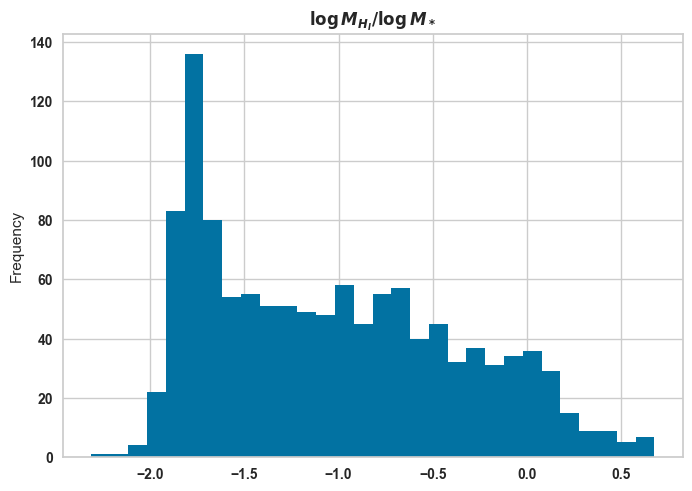

In [ ]:
##### Set up features for the model #####
# Define magnitude-related features for brightness and color information
magnitude_features = [
    "model_r",  # r-band model magnitude (brightness), adjusted for extinction
    "NUVr"      # NUV-to-r color index (extinction-corrected), showing recent star formation activity
]

# Define morphological features for structural and shape-related information
morphological_features = [
    "expAB_r",    # Axial ratio from exponential disk fit, hints at disk vs. bulge structure
    "petrR50_r",  # Radius enclosing 50% of Petrosian flux in r-band, giving galaxy size
    "CINDX",      # Concentration index, helps indicate disk- vs. bulge-dominance
    "INCL"        # Galaxy inclination angle, affecting observed structure and brightness
]

# Merge the selected feature groups into a single list
features = magnitude_features + morphological_features # 'features' now holds the column names used as input for our model

# Target variable
target = 'lgGF'

_ = df[target].plot.hist(bins=30, title=r'$\log{M_{H_I}/\log M_*}$')

### EDA

In [ ]:
# check for missing values in the target
df.isna().sum()

GASS                0
AGCnr               0
SDSS                0
PLATEID             0
MJD                 0
FIBERID             0
RA                  0
DEC                 0
zSDSS               0
Dlum                0
lgMstar             0
expAB_r             0
model_r             0
merr_r              0
ext_r               0
petrR50_r           0
petrR90_r           0
petrR50_z           0
lgmust              0
CINDX               0
INCL                0
NUVr                0
lgSFR_tot_median    1
SFR_best            0
SFRerr_best         0
SFRcase_best        0
HIsrc               0
HI_FLAG             0
xGASSDR             0
zHI                 0
W50cor              0
lgMHI               0
lgGF                0
HIconf_flag         0
weight              0
group_id_B          0
NYU_id              0
env_code_B          0
Ngal_B              0
yang_shred_code     0
logMh_Mst_B         0
lvir_ratB           0
dtype: int64

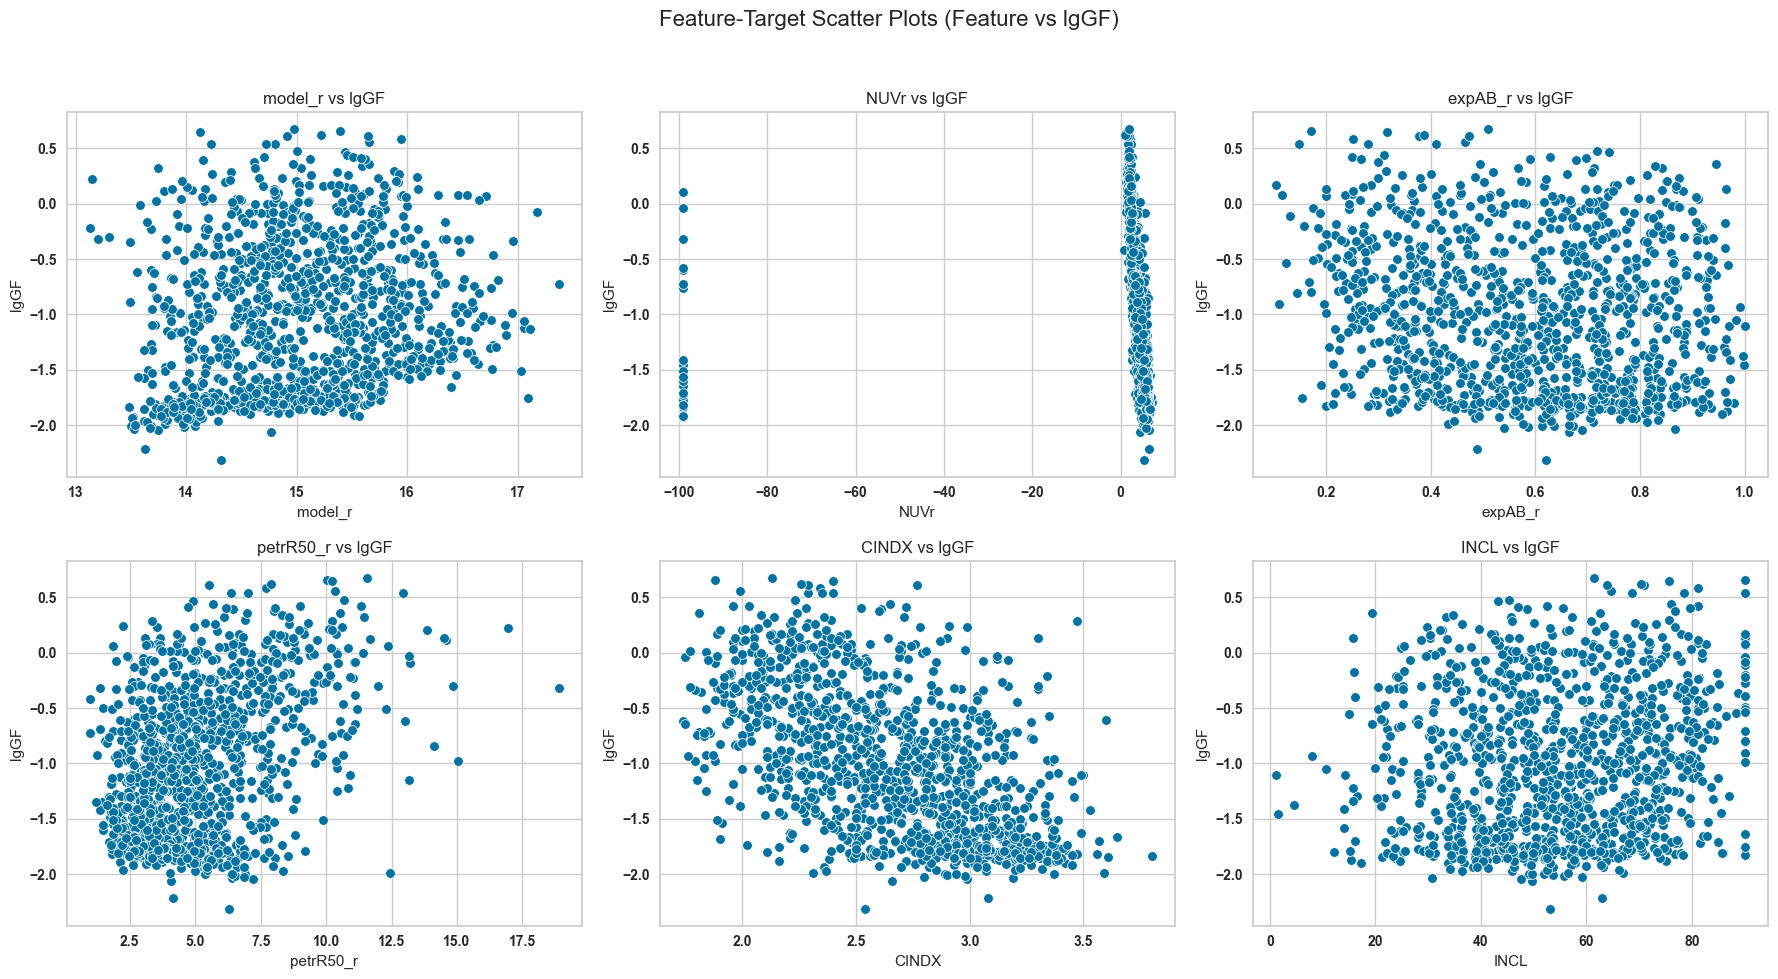

In [ ]:
# Scatter plots for each feature vs lgGF
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Feature-Target Scatter Plots (Feature vs lgGF)", fontsize=16)

sns.scatterplot(x="model_r", y="lgGF", data=df, ax=axes[0, 0])
axes[0, 0].set_title("model_r vs lgGF")

sns.scatterplot(x="NUVr", y="lgGF", data=df, ax=axes[0, 1])
axes[0, 1].set_title("NUVr vs lgGF")

sns.scatterplot(x="expAB_r", y="lgGF", data=df, ax=axes[0, 2])
axes[0, 2].set_title("expAB_r vs lgGF")

sns.scatterplot(x="petrR50_r", y="lgGF", data=df, ax=axes[1, 0])
axes[1, 0].set_title("petrR50_r vs lgGF")

sns.scatterplot(x="CINDX", y="lgGF", data=df, ax=axes[1, 1])
axes[1, 1].set_title("CINDX vs lgGF")

sns.scatterplot(x="INCL", y="lgGF", data=df, ax=axes[1, 2])
axes[1, 2].set_title("INCL vs lgGF")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

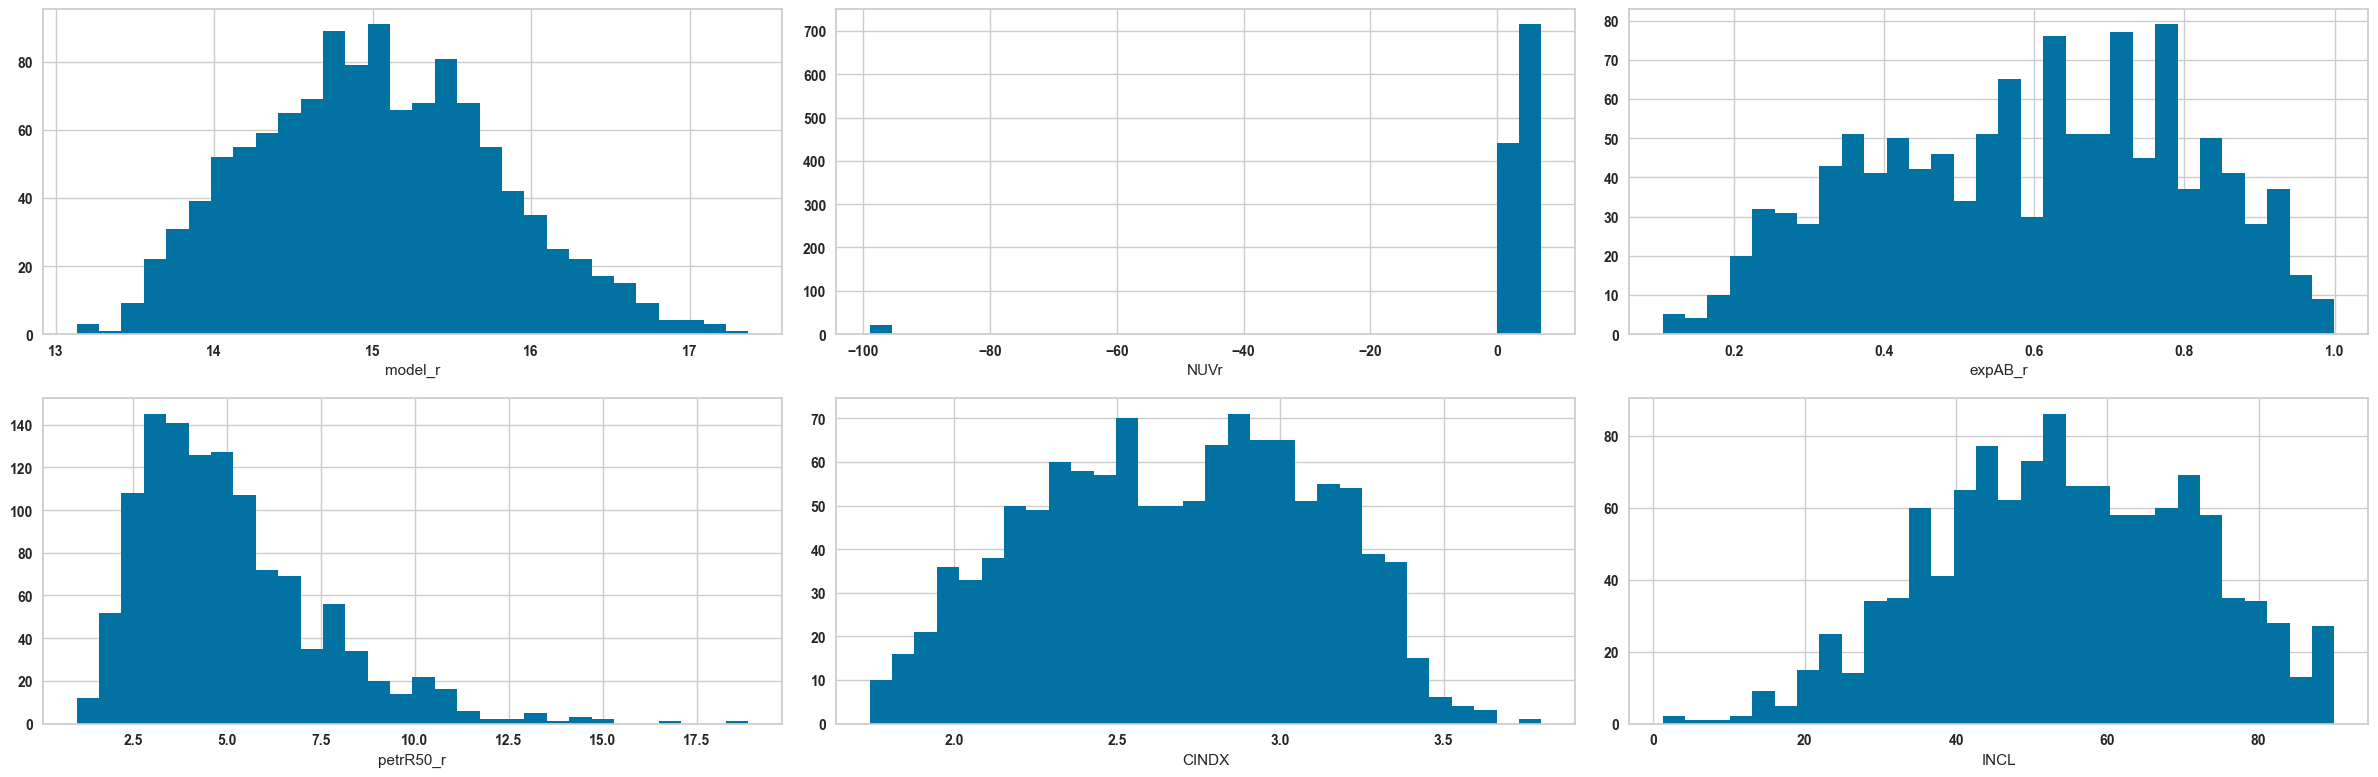

In [ ]:
# Create a 2x3 grid of subplots with specified figure size and resolution
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 8), dpi=100)

# Loop through features and corresponding subplot axes to plot histograms
for i, ax in enumerate(axes.ravel()):
    feature = features[i]  # Get the feature name for the current index
    df[feature].plot(kind='hist', bins=30, ax=ax)  # Plot histogram with 20 bins and set color
    ax.set_xlabel(feature)  # Set the x-axis label as the feature name
    ax.set_ylabel('')       # Leave the y-axis label blank for a cleaner look

fig.tight_layout()

In [ ]:
# Identify galaxies with missing NUVr color values
missing_NUVr_count = (df['NUVr'] < -90).sum()  # Count of galaxies with NUVr < -90
total_galaxies = len(df)                       # Total number of galaxies in the dataset

# Print the count of missing color data and total galaxies
print(f'Missing NUVr color values: {missing_NUVr_count} out of {len(df)}')

Missing NUVr color values: 22 out of 1179


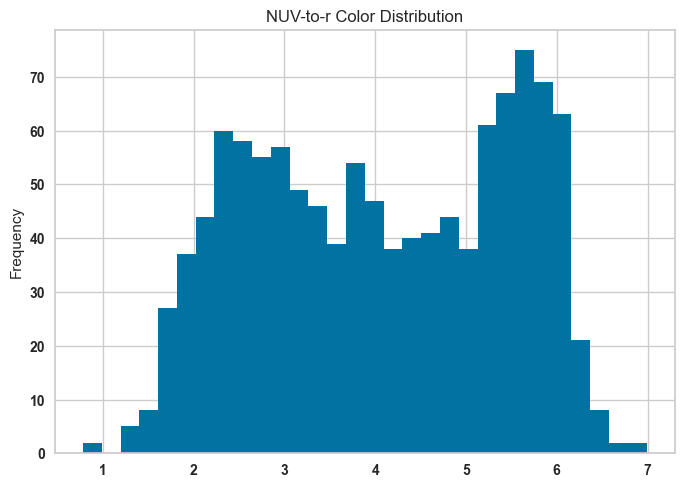

In [ ]:
# Remove them!
df = df[df['NUVr'] > -90].copy()
_ = df['NUVr'].plot(kind='hist', bins=30, title='NUV-to-r Color Distribution')

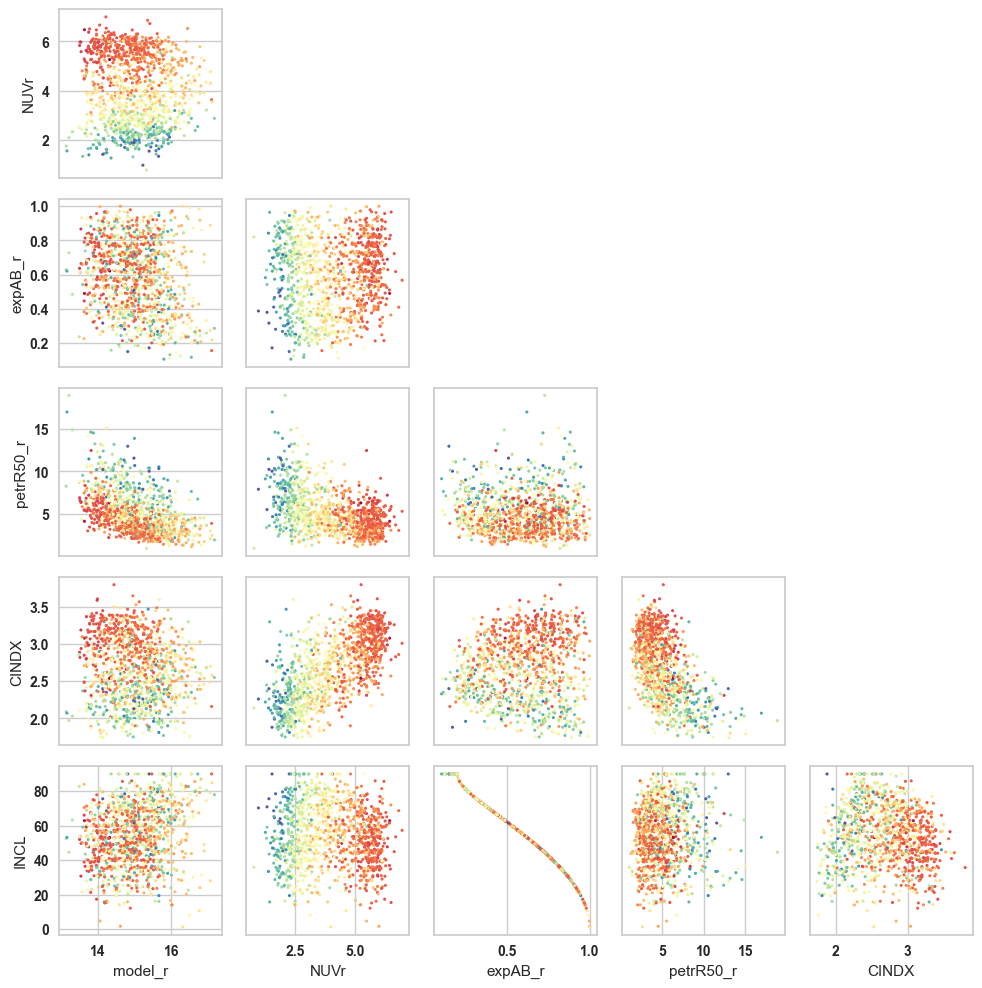

In [ ]:
# Set up a square grid of subplots based on the number of features
fig, axes = plt.subplots(nrows=len(features), ncols=len(features), figsize=(12, 12), dpi=100)

# Loop through each pair of features to populate scatter plots
for row_idx, col_y in enumerate(features):
    for col_idx, col_x in enumerate(features):
        ax = axes[row_idx, col_idx]  # Access specific subplot

        # Only fill plots below the diagonal to avoid repetition
        if row_idx <= col_idx:
            ax.set_visible(False)  # Hide plots above the diagonal
        else:
            # Scatter plot with color representing the target gas fraction
            scatter = ax.scatter(x=df[col_x], y=df[col_y], c=df[target].values, s=5,
                                 edgecolor='none', cmap='Spectral')

        # Set x-axis labels only for plots in the last row
        if row_idx == len(features) - 1:
            ax.set_xlabel(col_x)
        else:
            ax.set_xticks([])  # Remove x-ticks for clarity

        # Set y-axis labels only for plots in the first column
        if col_idx == 0:
            ax.set_ylabel(col_y)
        else:
            ax.set_yticks([])  # Remove y-ticks for non-first-column plots

fig.tight_layout()

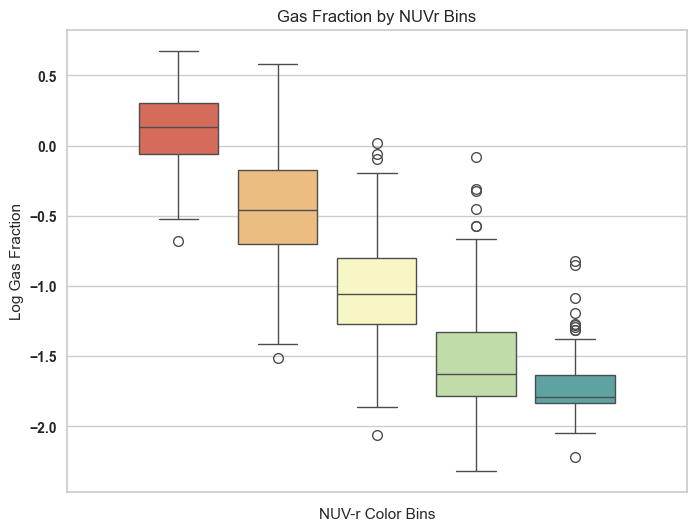

In [ ]:
df['NUVr_bin'] = pd.cut(df['NUVr'], bins=5)  # Bin NUVr into 5 intervals

plt.figure(figsize=(8, 6))
sns.boxplot(y=target, hue = 'NUVr_bin', data=df, palette='Spectral', legend = False, gap=.2)
plt.title('Gas Fraction by NUVr Bins')
plt.xlabel('NUV-r Color Bins')
plt.ylabel('Log Gas Fraction')
plt.show()

### Try linear regression as a baseline model

In [ ]:
# Selecting the features and target variable from the dataset, dropping any rows with NaN values
data = df[features + [target]]

# Separate features and target variable
X = data[features].values
y = data[[target]].values

# Add a column of ones to X to account for the intercept term in the normal equation
X = np.c_[np.ones(X.shape[0]), X]  # adding the intercept term

# Using the Normal Equation: theta = (X.T * X)^-1 * X.T * y
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

theta


array([[-2.6266357 ],
       [ 0.19499454],
       [-0.40462567],
       [-0.68288805],
       [ 0.06363814],
       [ 0.27009117],
       [-0.00607879]])

In [ ]:
# Predicting y values using the calculated theta
y_pred = X.dot(theta)

# Calculating R-squared
ss_total = np.sum((y - np.mean(y))**2)  # Total sum of squares
ss_residual = np.sum((y - y_pred)**2)   # Residual sum of squares
r_squared = 1 - (ss_residual / ss_total)

r_squared

0.7872763889967058

In [ ]:
# Define the linear regression model
model = LinearRegression()

# Perform 5-fold cross-validation to evaluate the model
scores = cross_val_score(model, data[features], data[[target]], cv=5, scoring='r2')

# Calculate the mean and standard deviation of the R^2 scores across folds
mean_r2 = scores.mean()
std_r2 = scores.std()

mean_r2, std_r2

(0.7680162170339272, 0.06196366766123985)

### Main Model

In [ ]:
from pycaret.regression import *
_ = setup(data = df[features + [target]], target = target, session_id=123,
                  normalize = True, transformation = True, transform_target = True)

,Description,Value
0,Session id,123
1,Target,lgGF
2,Target type,Regression
3,Original data shape,"(1157, 7)"
4,Transformed data shape,"(1157, 7)"
5,Transformed train set shape,"(809, 7)"
6,Transformed test set shape,"(348, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.2159,0.0875,0.2953,0.8098,0.1543,0.9897,0.2420
gbr,Gradient Boosting Regressor,0.2155,0.0882,0.2959,0.8084,0.1540,0.9232,0.0380
rf,Random Forest Regressor,0.2183,0.0890,0.2973,0.8066,0.1572,0.9741,0.0590
huber,Huber Regressor,0.2233,0.0895,0.2982,0.8047,0.1526,0.8594,0.0090
et,Extra Trees Regressor,0.2224,0.0899,0.2990,0.8044,0.1576,0.9477,0.0430
lr,Linear Regression,0.2256,0.0904,0.2999,0.8026,0.1539,0.8895,0.0310
ridge,Ridge Regression,0.2258,0.0905,0.2999,0.8026,0.1538,0.8894,0.0120
lar,Least Angle Regression,0.2256,0.0904,0.2999,0.8026,0.1539,0.8895,0.0090
br,Bayesian Ridge,0.2258,0.0905,0.3000,0.8026,0.1538,0.8894,0.0090
lightgbm,Light Gradient Boosting Machine,0.2282,0.0974,0.3113,0.7884,0.1619,1.0305,0.2670


In [ ]:
catboost_model = create_model('catboost')
gbr_model = create_model('gbr')
rf_model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2060,0.0885,0.2975,0.8055,0.1634,1.5938
1,0.2184,0.0833,0.2886,0.7982,0.1484,0.4500
2,0.2304,0.1003,0.3167,0.8103,0.1598,2.0899
3,0.2249,0.0874,0.2957,0.8459,0.1514,1.0259
4,0.2254,0.0888,0.2979,0.7885,0.1531,0.5170
5,0.2106,0.0887,0.2978,0.8100,0.1492,0.5175
6,0.2025,0.0777,0.2787,0.8290,0.1501,0.5331
7,0.2448,0.1046,0.3235,0.7774,0.1668,0.7594
8,0.2017,0.0666,0.2580,0.8441,0.1397,0.8854


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1993,0.0812,0.2850,0.8215,0.1574,1.4446
1,0.2212,0.0871,0.2951,0.7890,0.1516,0.4732
2,0.2325,0.1041,0.3227,0.8031,0.1660,2.0800
3,0.2220,0.0824,0.2871,0.8547,0.1464,1.0380
4,0.2167,0.0883,0.2971,0.7897,0.1539,0.4470
5,0.2104,0.0888,0.2979,0.8098,0.1493,0.5446
6,0.2093,0.0858,0.2930,0.8111,0.1529,0.5795
7,0.2560,0.1141,0.3378,0.7572,0.1707,0.6250
8,0.1798,0.0570,0.2388,0.8664,0.1285,0.6278


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1969,0.0779,0.2791,0.8288,0.1559,1.5422
1,0.2127,0.0788,0.2808,0.8090,0.1464,0.4741
2,0.2351,0.1062,0.3259,0.7992,0.1658,2.0142
3,0.2260,0.0878,0.2962,0.8453,0.1574,1.1211
4,0.2264,0.0971,0.3116,0.7687,0.1606,0.5646
5,0.2155,0.0884,0.2973,0.8107,0.1509,0.5197
6,0.2113,0.0851,0.2917,0.8127,0.1589,0.6174
7,0.2431,0.1088,0.3299,0.7685,0.1676,0.6528
8,0.1885,0.0583,0.2415,0.8634,0.1293,0.7491


In [ ]:
tuned_catboost = tune_model(catboost_model)
tuned_gbr = tune_model(gbr_model)
tuned_rf = tune_model(rf_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1972,0.0798,0.2824,0.8247,0.1510,1.4780
1,0.2076,0.0773,0.2780,0.8127,0.1417,0.4385
2,0.2205,0.0909,0.3015,0.8281,0.1547,2.1307
3,0.2257,0.0804,0.2835,0.8583,0.1487,1.0480
4,0.2078,0.0805,0.2837,0.8083,0.1450,0.4124
5,0.2142,0.0861,0.2934,0.8156,0.1455,0.5852
6,0.2098,0.0848,0.2911,0.8134,0.1547,0.6013
7,0.2398,0.1094,0.3307,0.7673,0.1685,0.6381
8,0.1802,0.0565,0.2376,0.8677,0.1275,0.5620


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2203,0.0979,0.3129,0.7849,0.1716,1.6915
1,0.2217,0.0867,0.2944,0.7900,0.1475,0.4207
2,0.2200,0.1020,0.3194,0.8071,0.1591,1.3849
3,0.2408,0.1010,0.3178,0.8219,0.1683,1.1456
4,0.2260,0.0911,0.3019,0.7828,0.1585,0.6272
5,0.2225,0.1019,0.3193,0.7816,0.1589,0.4587
6,0.2198,0.0877,0.2962,0.8069,0.1560,0.5289
7,0.2555,0.1146,0.3386,0.7561,0.1753,0.8718
8,0.2182,0.0741,0.2723,0.8263,0.1510,1.0162


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2094,0.0837,0.2894,0.8160,0.1551,1.6036
1,0.2259,0.0857,0.2928,0.7923,0.1494,0.5220
2,0.2524,0.1142,0.3380,0.7840,0.1701,1.5814
3,0.2417,0.0987,0.3141,0.8261,0.1701,1.1919
4,0.2249,0.0910,0.3017,0.7831,0.1582,0.6797
5,0.2275,0.0928,0.3047,0.8011,0.1492,0.5942
6,0.2166,0.0898,0.2996,0.8024,0.1518,0.6354
7,0.2588,0.1108,0.3328,0.7643,0.1643,0.7362
8,0.1993,0.0641,0.2531,0.8499,0.1403,1.4047


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
blend_all = blend_models([tuned_catboost, tuned_gbr, tuned_rf])
final_model = finalize_model(blend_all)
predict_model(final_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1923,0.0770,0.2776,0.8307,0.1524,1.4808
1,0.2098,0.0784,0.2799,0.8101,0.1456,0.4339
2,0.2258,0.0974,0.3121,0.8158,0.1604,2.0679
3,0.2191,0.0797,0.2824,0.8594,0.1473,1.0349
4,0.2143,0.0867,0.2945,0.7934,0.1519,0.4585
5,0.2093,0.0858,0.2928,0.8163,0.1466,0.5414
6,0.2053,0.0828,0.2877,0.8178,0.1545,0.5897
7,0.2439,0.1081,0.3287,0.7701,0.1668,0.5958
8,0.1793,0.0549,0.2343,0.8714,0.1265,0.5502


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1459,0.0406,0.2015,0.8944,0.1126,0.5849


,model_r,NUVr,expAB_r,petrR50_r,CINDX,INCL,lgGF,prediction_label
255,16.602501,3.76,0.461498,2.64,2.70,64.900002,-0.743,-0.927624
1022,13.966900,4.77,0.569139,6.87,3.08,57.099998,-1.829,-1.552000
145,14.672800,5.42,0.728843,5.72,3.06,44.299999,-1.380,-1.582504
846,14.969800,1.80,0.515913,2.43,2.69,61.000000,-0.039,-0.054455
921,14.001100,4.25,0.761504,7.20,2.36,41.400002,-1.603,-1.551698
...,...,...,...,...,...,...,...,...
693,14.289800,4.60,0.903860,7.71,2.40,25.900000,-1.577,-1.532916
533,15.350800,5.47,0.571745,3.21,2.80,56.900002,-1.170,-1.540897
104,15.955800,5.09,0.335102,3.60,2.82,74.099998,-1.107,-1.240587
314,14.834800,2.09,0.364231,8.50,1.96,71.900002,0.101,0.060605


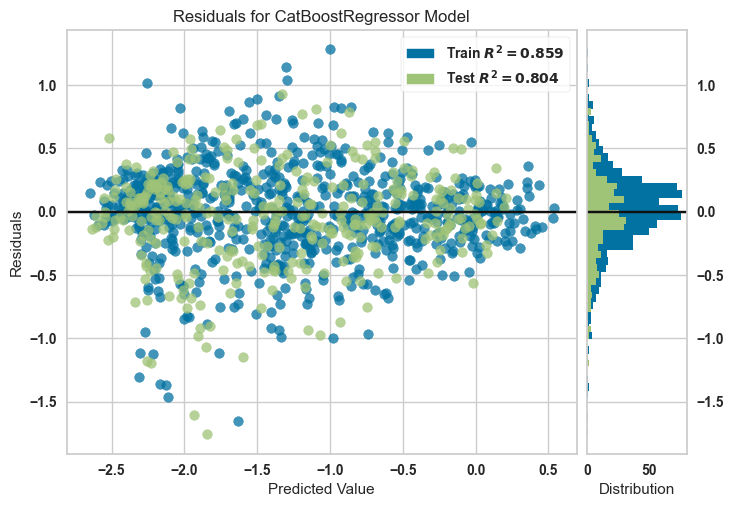

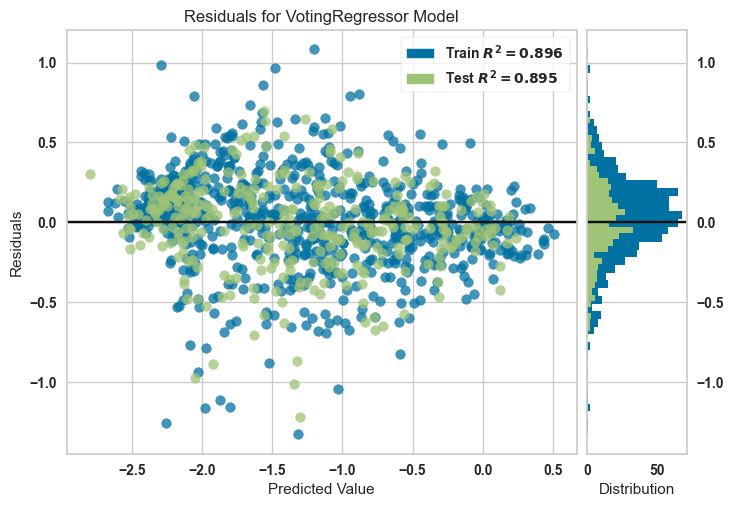

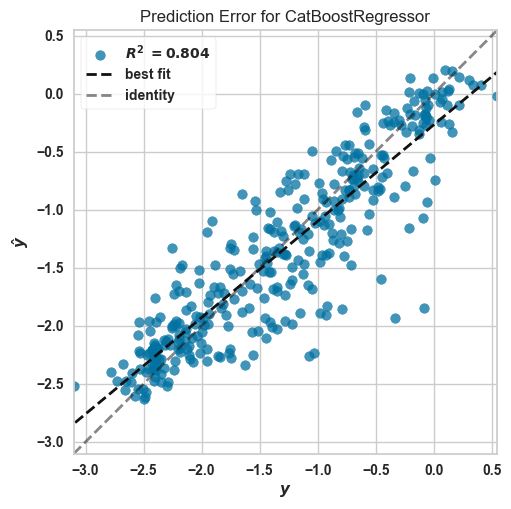

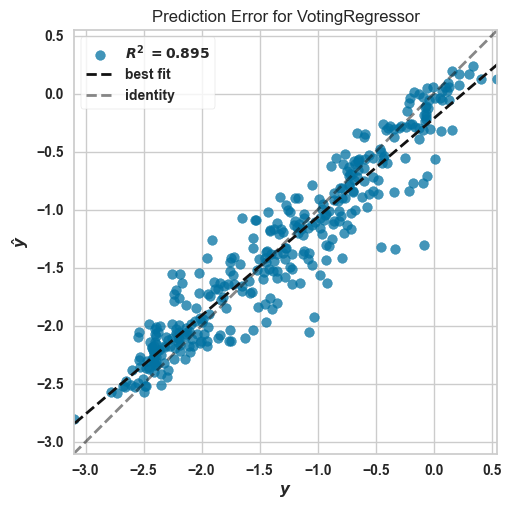

In [ ]:
# plot residuals
plot_model(tuned_catboost, plot = 'residuals')
plot_model(final_model, plot = 'residuals')

# plot error
plot_model(tuned_catboost, plot = 'error')
plot_model(final_model, plot = 'error')
